Ya sabemos como funciona el univariado_unistep, me da una variable y me da un step de tiempo, o sea, solo predigo 10minxd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [ ]:
# cambiar la ruta
df = pd.read_csv('weather_dataset_PREprocesado.csv')

hacer el split de datos

In [3]:
def train_val_test_split(serie, tr=0.8, ts=0.1, vl=0.1):
    N = len(serie)
    Ntrain = int(N*tr)
    Nval = int(N*vl)
    Ntest = int(N*ts)

    train = serie[:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    print(f'train: {train.shape}')
    print(f'val: {val.shape}')
    print(f'test: {test.shape}')

    return train, val, test


In [4]:
# recordar que es UNIVARIADO, por lo que será solo T (degC)
train, val, test = train_val_test_split(df['T (degC)'])

train: (336614,)
val: (42076,)
test: (42078,)


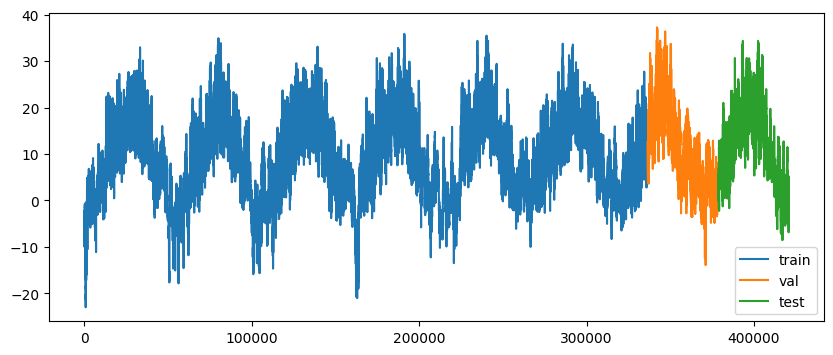

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train, label='train')
ax.plot(val, label='val')
ax.plot(test, label='test')
plt.legend()

Acá lo que hago es crear un dataset supervisado...
- Sacamos las filas y las columnas, cuando es una sola dimensión sale por ejemplo, `(3444,)` y no sale el uno, entonces es necesario ponerlo. Si no es univariado pues no es necesario ponerle el uno, saldría `(3444,2)`.

La parte supervisada es como el split que hicimos arriba.
- El `range(rows - input_length - output_length)` no permite que la iteración se salga de los límites.
- La `X` va agarrando el input de entrada y avanzando según la i, por ejemplo
```python
    input_length = 3
    array = [1, 2, 3, 4, 5]
    X = []
    # Iteración 1 (i=0):
    X.append([1, 2, 3])
    # Iteración 2 (i=1):
    X.append([2, 3, 4])
    # Iteración 3 (i=2):
    X.append([3, 4, 5])

    # si fuesen más columnas pues seria algo tipo
    array = np.array([[1, 10], [2, 20], [3, 30], [4, 40], [5, 50]])
    # primera itración
    array[0:2, :2]  # Resultado: [[ 1, 10], [ 2, 20]]
    # segunda iteración y así...
    array[1:3, :2]  # Resultado: [[ 2, 20], [ 3, 30]]
```
- La `Y` es lo mismo, empieza desde lo que agarra `X`, hasta lo que agarra `X` más la salida, y escoge la ultima columna que se supone que es el target, luego ahí hace el reshape para que quede de una dimension, tipo `(6,1)` en mi caso, por ejemplo
```python
    # una es temp y la otra humedad
    serie = [[1, 10],
            [2, 20],
            [3, 30],
            [4, 40],
            [5, 50],
            [6, 60],
            [7, 70],
            [8, 80]]

    # Teniendo esto...
    input_length = 3
    output_length = 2

    # La primera iteración llegaria hasta el 3 y coge 4,5, pero 4,5 están en temp, y queremos es humedad, entonces es 40,50.
    array[3:5, -1] = [40, 50]

    # Luego el reshape lo que hace es que cambia de (2,) a (2,1), esto es para que me quede como columna y ya
```

In [6]:
def crear_dataset_supervisado(array, input_length, output_length):
    X, Y = [], []

    # Sacamos filas y columnas
    shape = array.shape
    if len(shape) ==1:
        rows, cols = array.shape[0], 1
        array = array.reshape(rows, cols)
    else:
        rows, cols = array.shape

    # Ahora creamos el supervisado, con X y Y
    for i in range(rows - input_length - output_length):
        X.append(array[i:i+input_length, :cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    X = np.array(X)
    Y = np.array(Y)

    return X, Y


Esto es un poco confuso, voy a poner en ``input_length`` 144, o sea que el batch va a ser de 144, que son 24 horas, (1440 son 24 horas, dividido en 10, seria 144), y ``output_length`` 6, que es una hora. todo esto es porque tenemos steps de 10min

In [7]:
# como lo tengo de 10min, 144 seria 24 horas
input_length = 144
# lo ideal seria poner 6, que son una hora, pero como es uni-step...
output_length = 1

x_train, y_train = crear_dataset_supervisado(train.values, input_length,output_length)
x_val, y_val = crear_dataset_supervisado(val.values, input_length, output_length)
x_test, y_test = crear_dataset_supervisado(test.values, input_length, output_length)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (336469, 144, 1), y_train: (336469, 1, 1)
x_val: (41931, 144, 1), y_val: (41931, 1, 1)
x_test: (41933, 144, 1), y_test: (41933, 1, 1)


## Escalamiento

In [8]:
def escalar_dataset(data_input):

    # Cuando creamos el supervisado dejamos las variables en la posición 2
    NFEATS = data_input['x_train'].shape[2]
    # Se instancia tantos escaladores como columnas, por qué? al parecer es una buena práctica para redes lstm
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # se crear arrays vacios, llenos con 0s
    x_train_s = np.zeros(data_input['x_train'].shape)
    x_val_s = np.zeros(data_input['x_val'].shape)
    x_test_s = np.zeros(data_input['x_test'].shape)
    y_train_s = np.zeros(data_input['y_train'].shape)
    y_val_s = np.zeros(data_input['y_val'].shape)
    y_test_s = np.zeros(data_input['y_test'].shape)

    # Acá escalamos columna por columna, es decir, por separado
    for i in range(NFEATS):
        x_train_s[:, :, i] = scalers[i].fit_transform(data_input['x_train'][:, :, i])
        x_val_s[:, :, i] = scalers[i].transform(data_input['x_val'][:, :, i])
        x_test_s[:, :, i] = scalers[i].transform(data_input['x_test'][:, :, i])

    # lo que entendí es que estos valores son simbólicos nada más, se usa 0 inicialmente para decir que es la única columna, pero bien podriamos usar 1, tambié se usa el ultimo escalador para dar a entender que es el último valor el target, aunque bien podria ser otro valor, no le vi sentido a los números asi que pienso que es simbólico.
    y_train_s[:,:,0] = scalers[-1].fit_transform(data_input['y_train'][:,:,0])
    y_val_s[:,:,0] = scalers[-1].transform(data_input['y_val'][:, :, 0])
    y_test_s[:,:,0] = scalers[-1].transform(data_input['y_test'][:, :, 0])

    data_scaled = {
        'x_train_s': x_train_s,
        'x_val_s': x_val_s,
        'x_test_s': x_test_s,
        'y_train_s': y_train_s,
        'y_val_s': y_val_s,
        'y_test_s': y_test_s
    }

    # Saco el primer escalador para luego hacer la transformacion inversa
    return data_scaled, scalers[0]

In [9]:
# la función de arriba pide un diccionario asi que lo creo
data_in = {
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'x_val': x_val,
    'y_val': y_val
}

# entonces escalo y saco los datos
data_s, scaler = escalar_dataset(data_in)
x_train_s, y_train_s = data_s['x_train_s'], data_s['y_train_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']
x_test_s, y_test_s = data_s['x_test_s'], data_s['y_test_s']

print(x_train.min(), x_train.max())
print(x_train_s.min(), x_train_s.max())

-23.01 35.86
-1.0 0.9999999999999999


## Creación de modelo

In [ ]:
# la semilla y una cosa de configuración
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

N_UNITS = 128
INPUT_SHAPE = (x_train.shape[1], x_train.shape[2])

model = Sequential()
model.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
# 1 o el output_lenght, que como es univariado es 1
model.add(Dense(1, activation='linear'))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer=RMSprop(learning_rate=1e-5), loss=rmse)

hist = model.fit(
    x_train_s, y_train_s,
    epochs=80,
    batch_size=256,
    validation_data=(x_val_s, y_val_s),
    verbose=2
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
1315/1315 - 19s - 14ms/step - loss: 0.0849 - val_loss: 0.0245
Epoch 2/80
1315/1315 - 18s - 14ms/step - loss: 0.0217 - val_loss: 0.0180
Epoch 3/80
1315/1315 - 17s - 13ms/step - loss: 0.0182 - val_loss: 0.0161
Epoch 4/80
1315/1315 - 17s - 13ms/step - loss: 0.0166 - val_loss: 0.0149
Epoch 5/80
1315/1315 - 21s - 16ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 6/80
1315/1315 - 17s - 13ms/step - loss: 0.0146 - val_loss: 0.0133
Epoch 7/80
1315/1315 - 17s - 13ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 8/80
1315/1315 - 17s - 13ms/step - loss: 0.0134 - val_loss: 0.0124
Epoch 9/80
1315/1315 - 17s - 13ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 10/80
1315/1315 - 17s - 13ms/step - loss: 0.0126 - val_loss: 0.0116
Epoch 11/80
1315/1315 - 20s - 15ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 12/80
1315/1315 - 17s - 13ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 13/80
1315/1315 - 21s - 16ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 14/80
1315/1315 - 20s - 16ms/step - loss:

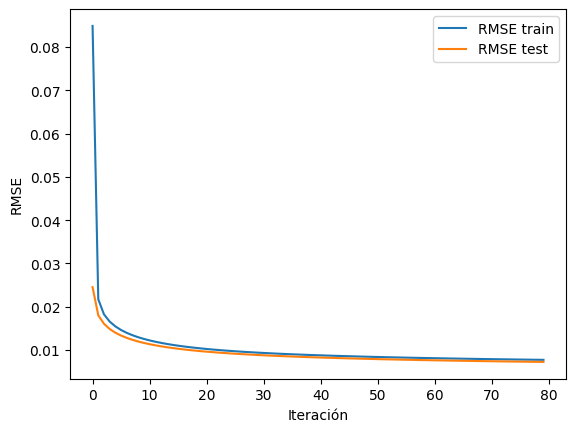

In [11]:
# Graficamos
plt.plot(hist.history['loss'],label='RMSE train')
plt.plot(hist.history['val_loss'], label='RMSE test')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## Desempeño

In [12]:
rmse_train = model.evaluate(x_train_s,y_train_s, verbose=0)
rmse_test = model.evaluate(x_test_s, y_test_s, verbose=0)
rmse_val = model.evaluate(x_val_s, y_val_s, verbose=0)

print("RMSE Train: ", rmse_train)
print("RMSE Test: ", rmse_test)
print("RMSE Val: ", rmse_val)

RMSE Train:  0.006560734007507563
RMSE Test:  0.006788815837353468
RMSE Val:  0.006541086360812187


In [13]:
def predecir(x,model,scaler):
    y_pred_s = model.predict(x, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [14]:
y_test_pred = predecir(x_test_s, model, scaler)

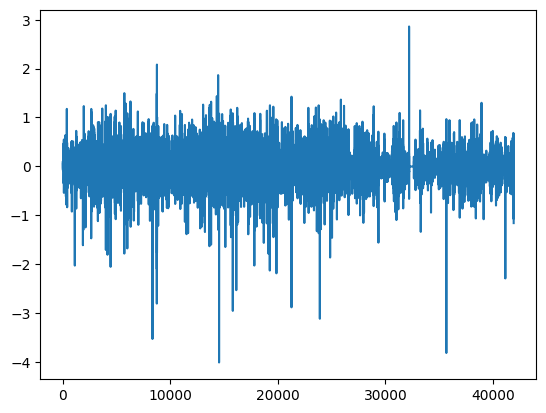

In [15]:
# Nunm de pred
N = len(y_test_pred)
# Esto es para graficar solo un arrelgo de 1 hasta N, de N en N, o sea, de uno en uno.
ndato = np.linspace(1,N,N)

errores = y_test.flatten() - y_test_pred
plt.plot(errores)